<a href="https://colab.research.google.com/github/GaryBall/CSML_notes/blob/master/heterograph_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount the google drive to colab
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [3]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install rdkit
# !pip install hydra-core wandb hydra-core ray ray-lightning torchmetrics overrides imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=d7737628ffd8e2d4a9a055f83df6a8aea738ce1a3f4f6adcb7cd0388c23aa964
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8

In [ ]:
%cd content
!git clone https://github.com/cvignac/MiDi/
%cd MiDi

[Errno 2] No such file or directory: 'content'
/content
fatal: destination path 'MiDi' already exists and is not an empty directory.
/content/MiDi


In [ ]:
from src.datasets import qm9_dataset

In [ ]:
import hydra
import omegaconf

@hydra.main(version_base='1.3', config_path='../configs', config_name='config')
def get_cfg(cfg: omegaconf.DictConfig):
  return cfg





In [ ]:
datamodule = qm9_dataset.QM9DataModule(cfg)
dataset_infos = qm9_dataset.QM9infos(datamodule=datamodule, cfg=cfg)

# Molecule Data

## QM9 dataset

In [ ]:
from torch_geometric.datasets import QM9
from torch_geometric.transforms import NormalizeFeatures

dataset = QM9(root='/tmp/QM9')
dataset = dataset[0:3000]

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: QM9(3000):
Number of graphs: 3000
Number of features: 11
Number of classes: 19

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:2000]
test_dataset = dataset[2000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 2000
Number of test graphs: 1000


# Synthetic data

In [4]:
import itertools
import random

# Define the nodes
nodes = ['A', 'B', 'C', 'D']

# Generate all binary combinations
combinations = list(itertools.combinations_with_replacement(nodes, 2))

# Calculate 40% of the total combinations
sample_size = round(len(combinations) * 0.4)

# Randomly sample a subset of the combinations
subset = random.sample(combinations, sample_size)

# Print the results
print("All binary combinations:", combinations)
print("Sampled subset (40%):", subset)


All binary combinations: [('A', 'A'), ('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'B'), ('B', 'C'), ('B', 'D'), ('C', 'C'), ('C', 'D'), ('D', 'D')]
Sampled subset (40%): [('C', 'C'), ('C', 'D'), ('B', 'D'), ('A', 'D')]


In [5]:
import numpy as np
import networkx as nx
import random

def random_unit_vector(K):
    """Generate a random K-dimensional unit vector."""
    v = np.random.randn(K)
    return v / np.linalg.norm(v)

def sample_vectors(K):
    # Generate random K-dimensional unit vectors for X and Y
    X = random_unit_vector(K)
    Y = random_unit_vector(K)

    # Compute the projection of Y onto X
    Y_proj_X = np.dot(X, Y) * X

    # Compute the orthogonal component of Y with respect to X
    Y_orth = Y - Y_proj_X

    # Compute Z by adding a scaled orthogonal component of Y to X
    Z = X + np.sqrt(1 - np.dot(X, Y)**2) * Y_orth / np.linalg.norm(Y_orth)

    return X, Y, Z

# Example usage:
K = 3

X, Y, Z = sample_vectors(K)

print("Sampled X:", X)
print("Sampled Y:", Y)
print("Sampled Z:", Z)
print("X^T * Y =", np.dot(X, Y))
print("Y^T * Z =", np.dot(Y, Z))


Sampled X: [-0.20645818 -0.83766477 -0.50566071]
Sampled Y: [-0.08627419 -0.0929522  -0.99192573]
Sampled Z: [-0.16942467 -0.43031945 -1.19557923]
X^T * Y = 0.5972526642115094
Y^T * Z = 1.2405419193037635


# Function for generating Heterogeneous Graphs 

- with Small world assumption - Watts Strogatz Graph

In [134]:
from IPython.terminal.embed import ultratb
import networkx as nx
import random
from collections import deque
from itertools import product
import numpy as np

def ws_graph (n,k,p):
  return nx.watts_strogatz_graph(n, k, p)

def get_available_node_types(current_node, graph, meta_graph):
    if current_node is not None:
      current_node_type = graph.nodes[current_node].get('type')
    else:
      current_node_type = None
    
    # process the case when we randomly select a node to start
    if not current_node_type:
        return list(meta_graph.keys())
    else:
        return list(meta_graph[current_node_type].keys())


def normalize_node_type_prob(available_types, node_type_prob):
    total_prob = sum(node_type_prob[available_types].values())
    node_type_prob_normalized = {}
    for node_type, prob in node_type_prob.items():
      normalized_prob = prob / total_prob
      node_type_prob_normalized[node_type] = normalized_prob

    return node_type_prob_normalized



def generate_heterogeneous_small_world(graph, meta_graph, node_type_prob):
    # Step 1: Generate a Watts-Strogatz graph
    

    # Step 2: Normalize node type probabilities
    node_type_prob_normalized = {node_type: prob / sum(node_type_prob.values()) for node_type, prob in node_type_prob.items()}
    print(node_type_prob_normalized)

    # Step 3: Assign node and edge types using BFS
    visited = set()
    print(graph.nodes())
    current_node = None
    last_node = None

    possible_rel = [(i,j) for i in meta_graph.keys() for j in meta_graph[i].keys()]

    for node in graph.nodes():
        if node not in visited:
            # BFS traversal
            queue = deque([node])
            
            visited.add(node)

            while queue:
                print(queue)
            
                current_node = queue.popleft()
                
                if not graph.nodes[current_node].get('type'):
                  possible_start_type = get_available_node_types(current_node, graph, meta_graph)
                  sample_prob = [node_type_prob_normalized[node_type] for node_type in possible_start_type]
                  node_type = random.choices(possible_start_type, sample_prob, k=1)[0]
                  graph.nodes[current_node]['type'] = node_type

                available_node_types = get_available_node_types(current_node, graph, meta_graph)

                # Assign edge types and add unvisited neighbors to queue
                for neighbor in graph.neighbors(current_node):
                    if neighbor not in visited:
                        # Assign node type
                        if not graph.nodes[neighbor].get('type'):
                            sample_prob = [node_type_prob_normalized[node_type] for node_type in available_node_types]
                            node_type = random.choices(available_node_types, sample_prob, k=1)[0]

                            print(graph.nodes[current_node].get('type'), available_node_types)

                            print("sampled node type for node {vnumber}: {vtype}".format(vnumber = neighbor, vtype = node_type))
                            graph.nodes[neighbor]['type'] = node_type

                        queue.append(neighbor)
                        visited.add(neighbor)

                last_node = current_node
            
    for u, v  in graph.edges():
      if (graph.nodes[u]['type'],graph.nodes[v]['type']) in possible_rel:
        print(u,v, graph.nodes[u]['type'], graph.nodes[v]['type'], meta_graph[graph.nodes[u]['type']][graph.nodes[v]['type']])
        graph.edges[u, v]['type'] = meta_graph[graph.nodes[u]['type']][graph.nodes[v]['type']]
      else:
        print(u,v, graph.nodes[u]['type'], graph.nodes[v]['type'], 'NA')
        graph.edges[u, v]['type'] = 'NA'
    
    return graph

meta_graph = {
    'A': {'C': 'rel_AC'},
    'B': {'C': 'rel_BC', 'E': 'rel_BE'},
    'C': {'A':'rel_AC','B':'rel_BC', 'D':'rel_CD'},
    'D': {'C':'rel_CD','D':'rel_DD', 'E':'rel_DE'}, 
    'E': {'B':'rel_BE','D':'rel_DE'}
}
node_type_prob = {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E':1}
num_nodes = 50
graph = ws_graph(num_nodes, 3, 0.5)
hetero_graph = generate_heterogeneous_small_world(graph, meta_graph, node_type_prob)


{'A': 0.2, 'B': 0.2, 'C': 0.2, 'D': 0.2, 'E': 0.2}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
deque([0])
B ['C', 'E']
sampled node type for node 26: E
deque([26])
E ['B', 'D']
sampled node type for node 27: D
deque([27])
D ['C', 'D', 'E']
sampled node type for node 28: E
D ['C', 'D', 'E']
sampled node type for node 2: C
deque([28, 2])
E ['B', 'D']
sampled node type for node 9: D
deque([2, 9])
C ['A', 'B', 'D']
sampled node type for node 38: D
deque([9, 38])
D ['C', 'D', 'E']
sampled node type for node 10: C
deque([38, 10])
deque([10])
C ['A', 'B', 'D']
sampled node type for node 11: B
deque([11])
B ['C', 'E']
sampled node type for node 12: E
deque([12])
E ['B', 'D']
sampled node type for node 13: B
deque([13])
B ['C', 'E']
sampled node type for node 14: C
B ['C', 'E']
sampled node type for node 33: C
deque([14, 33])
C ['A', 'B', 'D']
sample

## Graph_stats

In [135]:
# find unique relation types
def unique_rel(meta_graph):
  unique_elements = set()
  for inner_dict in meta_graph.values():
    for element in inner_dict.values():
      unique_elements.add(element)

  return unique_elements

print(sorted(unique_rel(meta_graph)))

['rel_AC', 'rel_BC', 'rel_BE', 'rel_CD', 'rel_DD', 'rel_DE']


$\nabla(f)$

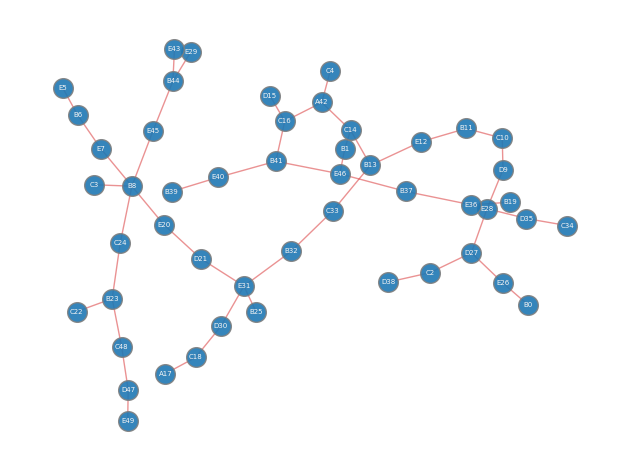

In [136]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(hetero_graph, seed=0)  # positions for all nodes

# nodes
options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
nx.draw_networkx_nodes(hetero_graph, pos, **options)

# edges
nx.draw_networkx_edges(hetero_graph, pos, width=1.0, alpha=0.5, edge_color="tab:red",)

labels = {i: graph.nodes[i]['type']+str(i) for i in range(len(graph.nodes))}
nx.draw_networkx_labels(hetero_graph, pos, labels, font_size=5, font_color="whitesmoke")

plt.tight_layout()
plt.axis("off")
plt.show()

In [137]:
import itertools

def adjacency_tensor(graph, meta_graph):
    edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
    n = len(graph.nodes())
    r = len(edge_types)

    adj_matrices = []

    for edge_type in edge_types:
        adj_matrix = np.zeros((n, n), dtype=np.int32)
        
        for u, v, data in graph.edges(data=True):
            if data['type'] == edge_type:
                adj_matrix[u, v] = 1
                adj_matrix[v, u] = 1
        
        adj_matrices.append(adj_matrix)

    edge_dict = {i: edge_types[i] for i in range(len(edge_types))}
    return np.stack(adj_matrices, axis=-1), edge_dict

adj_tsr, edge_dict = adjacency_tensor(hetero_graph, meta_graph)
adj_tsr.shape


(50, 50, 15)

In [138]:
edge_dict, meta_graph

({0: 'rel_AA',
  1: 'rel_AB',
  2: 'rel_AC',
  3: 'rel_AD',
  4: 'rel_AE',
  5: 'rel_BB',
  6: 'rel_BC',
  7: 'rel_BD',
  8: 'rel_BE',
  9: 'rel_CC',
  10: 'rel_CD',
  11: 'rel_CE',
  12: 'rel_DD',
  13: 'rel_DE',
  14: 'rel_EE'},
 {'A': {'C': 'rel_AC'},
  'B': {'C': 'rel_BC', 'E': 'rel_BE'},
  'C': {'A': 'rel_AC', 'B': 'rel_BC', 'D': 'rel_CD'},
  'D': {'C': 'rel_CD', 'D': 'rel_DD', 'E': 'rel_DE'},
  'E': {'B': 'rel_BE', 'D': 'rel_DE'}})

In [139]:
adj_tsr[:,:,2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [140]:
def adj_to_cov(W_GT, num_nodes):
  # W_GT = nx.adjacency_matrix(hetero_graph).todense()
  weights = np.random.lognormal(0, 0.2, (num_nodes, num_nodes))
  weights = (weights + weights.T) / 2
  
  W_GT = W_GT * weights
  W_GT = W_GT * num_nodes / (np.sum(W_GT)+1e-10)
  L_GT = np.diag(W_GT @ np.ones(num_nodes)) - W_GT
  
  cov_GT = np.linalg.inv(L_GT + (1e-1) * np.eye(num_nodes))
  return cov_GT



def generate_rel_signals(num_nodes, adj_tensor, sgl_dim):
  noise_sigma = 1e-02
  _ ,_, rel_num = adj_tensor.shape
  print(rel_num)
  emb_dim = sgl_dim * rel_num
  print(emb_dim, sgl_dim)
  signals_nodes = np.random.multivariate_normal(np.zeros(num_nodes), noise_sigma* np.eye(num_nodes), emb_dim)
  signals_edges = np.zeros((rel_num, emb_dim))
  
  for rel in range(rel_num):
    # the dimensions that are specific to relation type
    cov = adj_to_cov(adj_tensor[:,:,rel], num_nodes)
    # signals_rel = np.random.multivariate_normal(np.zeros(num_nodes), cov, sgl_dim)
    # the dimension that is not relevant to relation type
    signals_nodes[sgl_dim*rel:sgl_dim*(rel+1)] += np.random.multivariate_normal(np.zeros(num_nodes), cov, sgl_dim)
    signals_edges[rel, sgl_dim*rel:sgl_dim*(rel+1)] = 1/sgl_dim
  
  return signals_nodes.T, signals_edges

sgl_dim = 100
signal_vtx, signals_edge = generate_rel_signals(num_nodes, adj_tsr, sgl_dim)

15
1500 100


## From signal estimate Laplacian Matrix

In [125]:
def estimate_L(sgl_vtx, sgl_edge, dim):
  out_product = sgl_vtx[:, np.newaxis, np.newaxis, :] * sgl_vtx[np.newaxis, : ,np.newaxis, :] * sgl_edge[ np.newaxis, np.newaxis, :,  :]
  _,_,_,K = out_product.shape
  L_hat = np.linalg.inv((np.sum(out_product, axis = 3)[:,:,dim]/K))/K
  L_hat_undiag = L_hat *(1 - np.diag(L_hat))
  threshold = 0.7*(np.max(L_hat_undiag) - np.min(L_hat_undiag))+ np.min(L_hat_undiag)
  L_hat_undiag = (L_hat_undiag > threshold) * L_hat_undiag
  L_recover = - np.diag(L_hat_undiag @ np.ones(num_nodes)) + L_hat_undiag
  return L_recover

estimate_L(signal_vtx, signals_edge, 2)

array([[ 0., -0.,  0., ...,  0., -0., -0.],
       [-0.,  0., -0., ...,  0.,  0., -0.],
       [ 0., -0.,  0., ...,  0., -0., -0.],
       ...,
       [ 0.,  0.,  0., ...,  0., -0., -0.],
       [-0.,  0., -0., ..., -0.,  0.,  0.],
       [-0., -0., -0., ..., -0.,  0.,  0.]])

In [141]:
class ADMM():
    def __init__(self, l2_penalty, log_penalty, step_size=1e-02, relaxation_factor = 1.8):
        self.alpha = log_penalty  # the penalty before log barrier
        self.beta = l2_penalty  # the penalty before l2 term
        self.gn = step_size
        self.relax = relaxation_factor

    def initialisation(self, l, m, batch_size=1):
        w = torch.zeros((batch_size, l)).float().to(device)
        v = torch.zeros((batch_size, m)).float().to(device)
        return w, v

    def prox_log_barrier(self, y, gn, alpha):
        up = y ** 2 + 4 * gn * alpha
        up = torch.clamp(up, 1e-08)
        return (y - torch.sqrt(up)) / 2

    def objective(self, w, D, z):
        f1 = self.beta * torch.norm(w, 2) ** 2
        f2 = w.T @ z
        f3 = - self.alpha * torch.sum(torch.log(D @ w))

        if all(np.round(w, 4) >= 0):
            return f1 + f2 + f3
        else:
            return 10**3

    def solve(self, smooth, max_iter=1000, verbose=True):
        batch_size, m, _, r = smooth.shape
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth[:, mask].view(batch_size, -1)
        l = int(m*(m-1)*r/2)

        D_ori = coo_to_sparseTensor(get_degree_operator(m)).to(device)
        eye = torch.eye(int(m*(m-1)/2))
        shift_sum = eye.repeat_interleave(r, dim=1)
        D = D_ori @ shift_sum.to(device)

        # D * shift_sum if the new operator

        # initialise:
        w, v = self.initialisation(l, m, batch_size)
        zero_vec = torch.zeros((batch_size, l)).to(device)
        # w_list = torch.empty(size=(batch_size, max_ite, l))
        # print(w_list.shape)

        lambda_ = self.relax

        for i in range(max_iter):

            y1 = w - self.gn * (2 * self.beta * w + torch.matmul(v, D))
            p1 = torch.max(zero_vec, y1 - 2 * self.gn * z)

            y2 = v + self.gn * torch.matmul(2 * p1 - w, D.T)
            p2 = self.prox_log_barrier(y2, self.gn, self.alpha)

            w = w + lambda_ * (p1 - w)
            v = v + lambda_ * (p2 - v)

            # w_list[:, i, :] = w

        return w

#%%

class PDS():
    def __init__(self, l2_psi, log_psi, step_size):
        self.alpha = log_psi  # the penalty before log barrier
        self.beta = l2_psi  # the penalty before l2 term
        self.gn = step_size

    def prox_log_barrier(self, y, gn, alpha):
        return (y - torch.sqrt(y ** 2 + 4 * gn * alpha)) / 2

    def initialisation(self, l, m, batch_size):
        w = torch.zeros((batch_size, l)).float().to(device)
        v = torch.zeros((batch_size, m)).float().to(device)
        return w, v

    def solve(self, smooth, max_iter = 500):
        # z \in 1* m* m * r
        batch_size, m, _, r = smooth.shape
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth[:, mask].view(batch_size, -1)
        l = int(m*(m-1)*r/2)

        D_ori = coo_to_sparseTensor(get_degree_operator(m)).to(device)
        eye = torch.eye(int(m*(m-1)/2))
        shift_sum = eye.repeat_interleave(r, dim=1)
        D = D_ori @ shift_sum.to(device)

        # initialise:
        w, v = self.initialisation(l, m, batch_size)
        zero_vec = torch.zeros((batch_size, l)).to(device)
        # w_list = torch.empty(size=(batch_size, max_iter, l)).to(device)
        for i in range(max_iter):
            # print(z.shape)
            y1 = w - self.gn * (2 * self.beta * w + 2 * z + torch.matmul(v, D))
            y2 = v + self.gn * torch.matmul(w, D.T)

            p1 = torch.max(zero_vec, y1)
            p2 = self.prox_log_barrier(y2, self.gn, self.alpha)

            q1 = p1 - self.gn * (2 * self.beta * p1 + 2 * z + torch.matmul(p2, D))
            q2 = p2 + self.gn * torch.matmul(p1, D.T)

            w = w - y1 + q1
            v = v - y2 + q2

            # w_list[:, i, :] = w

        return w


In [142]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
def auc_test(model, loader, device):
  preds = []
  ground_truths = []
  model.to(device)
  model.eval()
  for test_batch in tqdm.tqdm(loader):
      test_batch = test_batch.to(device)
      preds.append(model(test_batch))
      with torch.no_grad():
        for edge_type in test_batch.edge_types:
          ground_truths.append(test_batch[edge_type].edge_label)
  pred = torch.cat(preds, dim=0).cpu().detach().numpy()
  # pred = pred/np.max(pred)
  ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
  auc = roc_auc_score(ground_truth, pred)
  f1 = f1_score(ground_truth, (pred>0.5))
  return auc, f1

In [143]:
pds_opt = PDS(1, 1, 1e-2)

In [163]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

def estimate_w(signal_vtx, signals_edge, adj_tensor, optimizer):
  diff_tensor = (signal_vtx[:, None, None, :] - signal_vtx[None,: , None, :]) * signals_edge[ None, None, :, :]
  diff_tensor = torch.Tensor(diff_tensor)
  num_nodes,_,num_relations ,K = diff_tensor.shape
  smooth_tensor = torch.norm(diff_tensor, dim=-1)**2
  # est_tensor = torch.exp(- 1/sigma * smooth_tensor)
  adj_tensor = torch.Tensor(adj_tensor).unsqueeze(0).to(device)
  mask = torch.triu(torch.ones(num_nodes, num_nodes), diagonal=1).bool()
  adj_vec = adj_tensor[:, mask].view(1, -1)
  print(smooth_tensor.shape)
  w = optimizer.solve(smooth_tensor.unsqueeze(0).to(device), max_iter = 500)
  # Normalization
  w = w/torch.max(w)
  GMSE_error = torch.sum(torch.square(w-adj_vec)/(w+1e-12))

  num_samples = w.shape[0] * w.shape[1]*w.shape[0]
  edge_indices = torch.where(adj_vec == 1)
  # Use these indices to access the corresponding elements in B
  out_edges = w[edge_indices]
  print(adj_vec[edge_indices])
  print(w)
  print(out_edges)
  link_error = torch.mean(torch.square(adj_vec[edge_indices] - out_edges))
  print(GMSE_error/num_samples)
  print(torch.sqrt(link_error))
  auc = roc_auc_score(adj_vec.to('cpu')[0], w.to('cpu')[0])
  f1 = f1_score(adj_vec.to('cpu')[0], (w>0.8).to('cpu')[0])
  print(auc, f1)
  # auc = roc_auc_score(adj_vec[edge_indices].to('cpu').detach().numpy(), out_edge


estimate_w(signal_vtx, signals_edge, adj_tsr, pds_opt)

torch.Size([50, 50, 15])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0780, 0.0017]],
       device='cuda:0')
tensor([0.9177, 0.7802, 0.8040, 0.9259, 1.0000, 0.8178, 0.9631, 0.8684, 0.8491,
        0.7792, 0.7406, 0.8238, 0.8172, 0.8991, 0.9152, 0.8845, 0.8673, 0.8551,
        0.8046, 0.8564, 0.8953, 0.9133, 0.8265, 0.9013, 0.9212, 0.8798, 0.8573,
        0.8404, 0.8569, 0.8760, 0.8845, 0.8614, 0.8399, 0.8472, 0.8905, 0.8669,
        0.8424, 0.7950, 0.8678, 0.9401, 0.8787, 0.8440, 0.8593, 0.8717, 0.8180,
        0.8329, 0.8441, 0.8793, 0.8900, 0.9675], device='cuda:0')
tensor(0.0442, device='cuda:0')
tensor(0.1436, device='cuda:0')
0.9994826739427013 0.7419354838709677


In [149]:
admm_opt = ADMM(l2_penalty=2, log_penalty=1, step_size=1e-02, relaxation_factor = 1.8)
estimate_w(signal_vtx, signals_edge, adj_tsr, admm_opt)

torch.Size([50, 50, 15])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[ 9.3078e-02, -2.9427e-44,  5.7762e-02,  ..., -2.9427e-44,
          1.6641e-01,  9.5891e-02]], device='cuda:0')
tensor([0.9519, 0.8509, 0.8758, 0.9388, 1.0000, 0.8812, 0.9650, 0.9385, 0.9189,
        0.8664, 0.8285, 0.8937, 0.8985, 0.9194, 0.9301, 0.9270, 0.9160, 0.9065,
        0.8700, 0.9062, 0.9256, 0.9198, 0.8712, 0.9219, 0.9439, 0.8959, 0.9051,
        0.8782, 0.8873, 0.9201, 0.9253, 0.9095, 0.8782, 0.8949, 0.9091, 0.9214,
        0.8798, 0.8581, 0.9152, 0.9520, 0.9108, 0.8998, 0.9200, 0.9185, 0.8673,
        0.8894, 0.9047, 0.9358, 0.9261, 0.9774], device='cuda:0')
tensor(0.0736, device='cuda:0')
tensor(0.0966, device='cuda:0')
0.999587448840382


# Graph Sampling from huge heterogeneous graph

Loading graphs

In [ ]:
from torch_geometric.datasets import DBLP

dataset_dblp = DBLP(root='./data/dblp')
data = dataset_dblp[0]

## Link Prediction

In [ ]:
from numpy.random.mtrand import noncentral_chisquare
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import HGTLoader

def data_preprocessing(data):
  # node type processing
  # for node_type in data.node_types:
  #   if data[node_type].x is None:
  data['conference'].x = torch.eye(data['conference'].num_nodes)

  # edge type processing
  edge_onehot = torch.eye(len(data.edge_types))
  i=0
  for edge_type in data.edge_types:
    data[edge_type].x = edge_onehot[i].reshape(1,-1)
    i+=1
  return data

def data_spliting(data):
  transform = RandomLinkSplit(num_val=0.3, num_test=0.2, 
                            is_undirected=True,
                            neg_sampling_ratio=1.0,
                            add_negative_train_samples=True,
                            edge_types=data.edge_types)
  train_test_split = transform(data)
  data_list = []
  for b_data in train_test_split:
    b_data.generate_ids()
    
    for edge_type in b_data.edge_types:
      b_data[edge_type].e_id = torch.arange(len(b_data[edge_type].edge_label))
      b_data[edge_type].edge_index = b_data[edge_type].edge_label_index
      del b_data[edge_type].edge_label_index
    data_list.append(b_data)
  
  return data_list

def data_batching(data, batch_size, input_nodes):
    loader = HGTLoader(
    data,
    # Sample 512 nodes per type and per iteration for 4 iterations
    num_samples={key: [16] * 4 for key in data.node_types},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size = batch_size,
    input_nodes=input_nodes,
    )
    return loader


data = data_preprocessing(data)
train_data, val_data, test_data = data_spliting(data)
train_loader = data_batching(train_data, 8, ('paper'))
val_loader = data_batching(val_data, 8, ('paper'))
test_loader = data_batching(test_data, 4, ('paper'))

In [ ]:
batch = next(iter(train_loader))
batch

HeteroData(
  author={
    x=[40, 334],
    y=[40],
    train_mask=[40],
    val_mask=[40],
    test_mask=[40],
    n_id=[40]
  },
  paper={
    x=[56, 4231],
    n_id=[56],
    input_id=[8],
    batch_size=8
  },
  term={
    x=[64, 50],
    n_id=[64]
  },
  conference={
    num_nodes=15,
    x=[15, 20],
    n_id=[15]
  },
  (author, to, paper)={
    edge_index=[2, 49],
    x=[1, 6],
    edge_label=[49],
    e_id=[49]
  },
  (paper, to, author)={
    edge_index=[2, 34],
    x=[1, 6],
    edge_label=[34],
    e_id=[34]
  },
  (paper, to, term)={
    edge_index=[2, 49],
    x=[1, 6],
    edge_label=[49],
    e_id=[49]
  },
  (paper, to, conference)={
    edge_index=[2, 2],
    x=[1, 6],
    edge_label=[2],
    e_id=[2]
  },
  (term, to, paper)={
    edge_index=[2, 80],
    x=[1, 6],
    edge_label=[80],
    e_id=[80]
  },
  (conference, to, paper)={
    edge_index=[2, 51],
    x=[1, 6],
    edge_label=[51],
    e_id=[51]
  }
)

In [ ]:
for edge_type in train_data.edge_types:
  print(train_data[edge_type].edge_label.shape)
for edge_type in train_data.edge_types:
  print(train_data[edge_type].edge_index.shape)

torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([2, 19646])
torch.Size([2, 19646])
torch.Size([2, 85810])
torch.Size([2, 14330])
torch.Size([2, 85810])
torch.Size([2, 14330])


In [ ]:
def get_complete_subgraph(subgraph, graph):
  for edge_type in subgraph.edge_types:
    # assuming edge_index is your edge index tensor with shape [2, E]
    # and sampled_nodes is your tensor of node indices to include in the subgraph

    # get the start and end nodes for each edge
    s_ntype, _, t_ntype = edge_type
    s_mapping = {old_id: new_id for new_id, old_id in enumerate(subgraph[s_ntype].n_id.tolist())}
    t_mapping = {old_id: new_id for new_id, old_id in enumerate(subgraph[t_ntype].n_id.tolist())}

    s_nodes, t_nodes = graph[edge_type].edge_index

    # find the indices of the edges where both the start node and end node are in sampled_nodes
    mask = (torch.isin(s_nodes, subgraph[s_ntype].n_id) & torch.isin(t_nodes, subgraph[t_ntype].n_id))
    print(mask.shape)

    # subset the edge index tensor to include only these edges
    subgraph_edge_index = graph[edge_type].edge_index[:, mask]
    s_idx, t_idx = subgraph_edge_index
    new_s_nodes = torch.tensor([s_mapping[node.item()] for node in s_idx])
    new_e_nodes = torch.tensor([t_mapping[node.item()] for node in t_idx])

    # create a new edge index tensor with the re-indexed node IDs
    subgraph[edge_type].edge_index = torch.stack([new_s_nodes, new_e_nodes])
    subgraph[edge_type].edge_label = graph[edge_type].edge_label[mask]
    subgraph[edge_type].e_id = graph[edge_type].e_id[mask]
  
  return subgraph

for batch in test_loader:
  batch = get_complete_subgraph(batch, train_data)



流式输出内容被截断，只能显示最后 5000 行内容。
torch.Size([85810])
torch.Size([14330])
torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([8

KeyError: ignored

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, HeteroDictLinear

class LinearProj(torch.nn.Module):
    def __init__(self, node_shape, edge_shape, out_channels):
        super().__init__()
        self.NodeLinear = HeteroDictLinear(in_channels=node_shape,out_channels=out_channels)
        self.EdgeLinear = HeteroDictLinear(in_channels=edge_shape,out_channels=out_channels)

    def forward(self, batch):
      node_attrs = {node_type: batch[node_type].x for node_type in batch.node_types}
      edge_attrs = {'_'.join(edge_type): batch[edge_type].x for edge_type in batch.edge_types}

      node_out = self.NodeLinear(node_attrs)
      edge_out = self.EdgeLinear(edge_attrs)
      
      for node_type in batch.node_types:
        node_out[node_type] = node_out[node_type]/(node_out[node_type].norm(dim=1)[:, None])
      for edge_type in edge_attrs:
        edge_out[edge_type] = edge_out[edge_type]/(edge_out[edge_type].norm(dim=1)[:, None])
      
      

      return (node_out, edge_out)


class Classifier(torch.nn.Module):
    def forward(self, s_node_x, t_node_x ,r_emb, edge_index):
        sigma = 1e-3
        s_idx, t_idx = edge_index[0], edge_index[1]
        s_nemb, t_nemb = s_node_x[s_idx], t_node_x[t_idx]
        diff_vector = r_emb * (s_nemb - t_nemb)
        smooth = torch.exp(- 1/sigma * torch.norm(diff_vector, dim=-1)**2)
        # print(diff_vector.shape, torch.norm(diff_vector, dim=-1).shape)
        # print(torch.norm(diff_vector, dim=-1)**2)
        # smooth = torch.exp(-1/sigma* (torch.norm(diff_vector, dim=-1)))
        
        return smooth


class Model(torch.nn.Module):
    def __init__(self, node_shape, edge_shape, out_channels=100):
        super().__init__()
        self.hetero_linear = LinearProj(node_shape, edge_shape, out_channels=100)
        self.classifier = Classifier()

    def forward(self, batch):

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        node_out, edge_out = self.hetero_linear(batch)
        pred_list = []
        for edge_type in batch.edge_types:
          s_ntype, _, t_ntype = edge_type
          s_emb, t_emb = node_out[s_ntype], node_out[t_ntype]
          r_emb = edge_out['_'.join(edge_type)]
          # print(self.classifier(s_emb, t_emb, r_emb, batch[edge_type].edge_index).shape)
          # print('gt: {}'.format(batch[edge_type].edge_label))
          # print('pred:{}'.format(self.classifier(s_emb, t_emb, r_emb, batch[edge_type].edge_index)))
          pred_list += [self.classifier(s_emb, t_emb, r_emb, batch[edge_type].edge_index)]
        pred = torch.cat(pred_list)
        return pred

In [ ]:
node_shape = {node_type: train_data[node_type].x.shape[-1] for node_type in train_data.node_types}
edge_shape = {'_'.join(edge_type): train_data[edge_type].x.shape[-1] for edge_type in train_data.edge_types}

model = Model(node_shape, edge_shape, out_channels=100)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
def auc_test(mode, loader, device):
  preds = []
  ground_truths = []
  model.to(device)
  model.eval()
  for test_batch in tqdm.tqdm(loader):
      test_batch = test_batch.to(device)
      preds.append(model(test_batch))
      with torch.no_grad():
        for edge_type in test_batch.edge_types:
          ground_truths.append(test_batch[edge_type].edge_label)
  pred = torch.cat(preds, dim=0).cpu().detach().numpy()
  pred = pred/np.max(pred)
  ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
  auc = roc_auc_score(ground_truth, pred)
  f1 = f1_score(ground_truth, (pred>0.5))
  return auc, f1

In [ ]:
import tqdm
import torch.nn.functional as F
from torch_geometric.loader import HGTLoader
from torch_geometric.loader import LinkNeighborLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: '{device}'")
model = model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 8,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-5) # Minimum learning rate
# Adam best learning rate: 1e-2, sigma= 1e-3, weight decay = 0
# SGD best learning rate: 1e-3, decay = 0.1, no sigma


for epoch in range(1, 21):
    total_loss = total_examples = 0
    for batch in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        pred = model(batch)
        
        gt_list = []
        for edge_type in batch.edge_types:
          gt_list.append(batch[edge_type].edge_label)
        ground_truth = torch.cat(gt_list)
        loss = F.binary_cross_entropy(pred, ground_truth, reduction='mean')
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    scheduler.step()
    
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}, learning_rate: {get_lr(optimizer):.4f}")
    if epoch % 10 == 0:
      auc_result, f1_sco = auc_test(model,test_loader, device)
      print(f"AUC: {auc_result:.4f}, f1 score: {f1_sco:.4f}")



Device: 'cuda:0'


  0%|          | 0/1791 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nested/__init__.py:58: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  return torch._nested_tensor_from_tensor_list(tensor_list, dtype, None, device, None)
100%|██████████| 1791/1791 [00:36<00:00, 49.44it/s]


Epoch: 001, Loss: 0.4249, learning_rate: 0.0096


100%|██████████| 1791/1791 [00:35<00:00, 50.16it/s]


Epoch: 002, Loss: 0.3198, learning_rate: 0.0085


100%|██████████| 1791/1791 [00:32<00:00, 54.81it/s]


Epoch: 003, Loss: 0.3001, learning_rate: 0.0069


100%|██████████| 1791/1791 [00:32<00:00, 55.34it/s]


Epoch: 004, Loss: 0.2869, learning_rate: 0.0050


  6%|▌         | 103/1791 [00:02<00:39, 42.98it/s]

In [ ]:
auc_result, f1 = auc_test(model,test_loader, device)
print(auc_result, f1)

100%|██████████| 3582/3582 [00:31<00:00, 112.47it/s]


0.8426684596019349 0.7002689798072096


In [ ]:
path = 'gdrive/MyDrive/heterograph_learning/linear_model.pth'
torch.save(model.state_dict(), path)

In [ ]:
# loading model
path = 'gdrive/MyDrive/heterograph_learning/linear_model.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
def batch_to_adjtensor(batch, node_out, edge_out):
  # create an empty dictionary to store the indices
  indices_dict = {}
  # list to hold the tensors
  tensor_list = []
  start_index = 0
  for node_type in batch.node_types:
    node_emb = node_out[node_type]
    end_index = start_index + node_emb.size(0)
    indices_dict[node_type] = (start_index, end_index)  # store the start and end index for this type
    tensor_list.append(node_emb)
    start_index = end_index  # update the start index for the next type
    # concatenate the tensors

  node_tensor = torch.cat(tensor_list, dim=0)

  adj_matrices = []
  # print('start transforming')
  for edge_type in batch.edge_types:
    # print(edge_type, batch[edge_type].edge_index)
    
    if batch[edge_type].edge_index.shape[-1] ==0:
        continue
    # Initialize the adjacency matrix
    N = node_tensor.size(0)
    adj_matrix = torch.zeros(N, N)
    # Populate the adjacency matrix
    s_ntype, _, e_ntype = edge_type
    start_indices = indices_dict[s_ntype]
    end_indices = indices_dict[e_ntype]

    # map the indices in edge_index to their corresponding indices in the big tensor
    edge_idx = batch[edge_type].edge_index
    edge_label = batch[edge_type].edge_label
    edge_idx[0] += start_indices[0]  # add the start index of the start node type to the start nodes in edge_index
    edge_idx[1] += end_indices[0]  # add the start index of the end node type to the end nodes in edge_index
    
    for i in range(edge_idx.shape[1]):
      if edge_label[i] == 1:
        one_edge = edge_idx[:, i]
        adj_matrix[one_edge[0], one_edge[1]] = 1
    adj_matrices.append(adj_matrix)

  adj_matrices = torch.stack(adj_matrices, dim=-1)
  return node_tensor, adj_matrices



In [ ]:
import itertools

step = 0
GMSE_error = 0
total_samples = 0
link_errors = []
sigma = 1e-3

for batch in tqdm.tqdm(test_loader):
  batch.to(device)
  model.to(device)
  step+=1
  node_out, edge_out = model.hetero_linear(batch)
  n_emb, adj_tensor = batch_to_adjtensor(batch, node_out, edge_out)
  # r_emb = [edge_out['_'.join(e_type)] for e_type in batch.edge_types if batch[e_type].edge_index.shape[0] != 0]
  r_emb = [edge_out['_'.join(e_type)] for e_type in batch.edge_types if batch[e_type].edge_index.shape[-1] != 0]
  
  r_emb = torch.cat(r_emb, dim=0)
  diff_tensor = (n_emb[:, None, None, :] - n_emb[None,: , None, :]) * r_emb[ None, None, :, :]
  num_nodes,_,num_relations ,K = diff_tensor.shape
  smooth_tensor = torch.norm(diff_tensor, dim=-1)**2
  est_tensor = torch.exp(- 1/sigma * smooth_tensor)
  adj_tensor = adj_tensor.to(device)
  GMSE_error += torch.sum(torch.square(est_tensor-adj_tensor))

  num_samples = est_tensor.shape[0] * est_tensor.shape[1]*est_tensor.shape[0]
  total_samples += num_samples

  edge_indices = torch.where(adj_tensor == 1)
  # Use these indices to access the corresponding elements in B
  out_edges = est_tensor[edge_indices]
  link_error = torch.mean(torch.square(adj_tensor[edge_indices] - out_edges))
  link_errors.append(torch.sqrt(link_error))

print(GMSE_error/total_samples)
print(torch.mean(torch.tensor(link_errors)))

# Find the indices of the 1 elements in A

'''
  # combinations = itertools.combinations_with_replacement(batch.node_types, 2)
  # possible_edge =  [(s_type,'to',t_type) for s_type,t_type in combinations]
  true_edge_types = batch.edge_types
  for edge_type in true_edge_types:
    if batch[edge_type].edge_index.shape[-1] ==0:
      continue
    if edge_type in true_edge_types:
      print(batch[edge_type].edge_index)
    s_ntype, _ , t_ntype = edge_type
    # source node embedding and target node embedding
    s_nemb, t_nemb = node_out[s_ntype], node_out[t_ntype]
    
    n_emb = torch.cat([s_nemb, t_nemb], dim=0)
    r_emb = edge_out['_'.join(edge_type)]
    out_product = n_emb[:, None, :] * n_emb[None,: , :] * r_emb[0][ None, None, :]
    N,_,K = out_product.shape
    out_adj = torch.sum(out_product, dim=2)
    print(out_adj.shape)
    # Use torch.topk to get the indices of K largest entrie
    values, indices = torch.topk(out_adj.view(-1), K)
    row_indices = indices // N
    col_indices = indices % N

    indices = torch.stack([row_indices, col_indices], dim=0)
    # Convert tensors to sets
    true_idx = batch[edge_type].edge_index
    true_idx[1] += s_nemb.shape[0]
    set1 = set(map(tuple, true_idx.t().tolist()))
    set2 = set(map(tuple, indices.t().tolist()))
    # Find the difference between sets
    print(set1,set2)
    acc = len(set1 - set2)/len(set1)
    print(acc)
'''
    
  
  

  9%|▉         | 162/1791 [00:04<00:45, 35.60it/s]


OutOfMemoryError: ignored

In [ ]:
print(GMSE_error/total_samples)
print(torch.mean(torch.tensor(link_errors)))

tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5301)


## Estimate adjacency tensor

In [21]:
import math
import scipy.sparse as sparse

def coo_to_sparseTensor(coo):
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

def get_degree_operator(m):
  
    ncols =int(m*(m - 1)/2)

    I = np.zeros(ncols)
    J = np.zeros(ncols)

    k = 0
    for i in np.arange(1, m):
        I[k:(k + m - i)] = np.arange(i, m)
        k = k + (m - i)

    k = 0
    for i in np.arange(1, m):
        J[k: (k + m - i)] = i - 1
        k = k + m - i

    Row = np.tile(np.arange(0, ncols), 2)
    Col = np.append(I, J)
    Data = np.ones(Col.size)
    St = sparse.coo_matrix((Data, (Row, Col)), shape=(ncols, m))
    return St.T

In [74]:
class ADMM():
    def __init__(self, l2_penalty, log_penalty, step_size=1e-02, relaxation_factor = 1.8):
        self.alpha = log_penalty  # the penalty before log barrier
        self.beta = l2_penalty  # the penalty before l2 term
        self.gn = step_size
        self.relax = relaxation_factor

    def initialisation(self, l, m, batch_size=1):
        w = torch.zeros((batch_size, l)).float().to(device)
        v = torch.zeros((batch_size, m)).float().to(device)
        return w, v

    def prox_log_barrier(self, y, gn, alpha):
        up = y ** 2 + 4 * gn * alpha
        up = torch.clamp(up, 1e-08)
        return (y - torch.sqrt(up)) / 2

    def objective(self, w, D, z):
        f1 = self.beta * torch.norm(w, 2) ** 2
        f2 = w.T @ z
        f3 = - self.alpha * torch.sum(torch.log(D @ w))

        if all(np.round(w, 4) >= 0):
            return f1 + f2 + f3
        else:
            return 10**3

    def solve(self, smooth, max_iter=1000, verbose=True):
        batch_size, m, _, r = smooth.shape
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth[:, mask].view(batch_size, -1)
        l = int(m*(m-1)*r/2)

        D_ori = coo_to_sparseTensor(get_degree_operator(m)).to(device)
        eye = torch.eye(int(m*(m-1)/2))
        shift_sum = eye.repeat_interleave(r, dim=1)
        D = D_ori @ shift_sum.to(device)

        # D * shift_sum if the new operator

        # initialise:
        w, v = self.initialisation(l, m, batch_size)
        zero_vec = torch.zeros((batch_size, l)).to(device)
        # w_list = torch.empty(size=(batch_size, max_ite, l))
        # print(w_list.shape)

        lambda_ = self.relax

        for i in range(max_iter):

            y1 = w - self.gn * (2 * self.beta * w + torch.matmul(v, D))
            p1 = torch.max(zero_vec, y1 - 2 * self.gn * z)

            y2 = v + self.gn * torch.matmul(2 * p1 - w, D.T)
            p2 = self.prox_log_barrier(y2, self.gn, self.alpha)

            w = w + lambda_ * (p1 - w)
            v = v + lambda_ * (p2 - v)

            # w_list[:, i, :] = w

        return w

#%%

class PDS():
    def __init__(self, l2_psi, log_psi, step_size):
        self.alpha = log_psi  # the penalty before log barrier
        self.beta = l2_psi  # the penalty before l2 term
        self.gn = step_size

    def prox_log_barrier(self, y, gn, alpha):
        return (y - torch.sqrt(y ** 2 + 4 * gn * alpha)) / 2

    def initialisation(self, l, m, batch_size):
        w = torch.zeros((batch_size, l)).float().to(device)
        v = torch.zeros((batch_size, m)).float().to(device)
        return w, v

    def solve(self, smooth, max_iter = 500):
        # z \in 1* m* m * r
        batch_size, m, _, r = smooth.shape
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth[:, mask].view(batch_size, -1)
        l = int(m*(m-1)*r/2)

        D_ori = coo_to_sparseTensor(get_degree_operator(m)).to(device)
        eye = torch.eye(int(m*(m-1)/2))
        shift_sum = eye.repeat_interleave(r, dim=1)
        D = D_ori @ shift_sum.to(device)

        # initialise:
        w, v = self.initialisation(l, m, batch_size)
        zero_vec = torch.zeros((batch_size, l)).to(device)
        # w_list = torch.empty(size=(batch_size, max_iter, l)).to(device)
        for i in range(max_iter):
            # print(z.shape)
            y1 = w - self.gn * (2 * self.beta * w + 2 * z + torch.matmul(v, D))
            y2 = v + self.gn * torch.matmul(w, D.T)

            p1 = torch.max(zero_vec, y1)
            p2 = self.prox_log_barrier(y2, self.gn, self.alpha)

            q1 = p1 - self.gn * (2 * self.beta * p1 + 2 * z + torch.matmul(p2, D))
            q2 = p2 + self.gn * torch.matmul(p1, D.T)

            w = w - y1 + q1
            v = v - y2 + q2

            # w_list[:, i, :] = w

        return w


In [ ]:
import itertools
from sklearn.metrics import roc_auc_score, f1_score

step = 0
GMSE_error = 0
total_samples = 0
link_errors = []
sigma = 1e-3

for batch in tqdm.tqdm(test_loader):
  step+=1
  batch.to(device)
  model.to(device)
  pds_opt = PDS(1, 1, 1e-2)
  
  node_out, edge_out = model.hetero_linear(batch)
  n_emb, adj_tensor = batch_to_adjtensor(batch, node_out, edge_out)
  # r_emb = [edge_out['_'.join(e_type)] for e_type in batch.edge_types if batch[e_type].edge_index.shape[0] != 0]
  r_emb = [edge_out['_'.join(e_type)] for e_type in batch.edge_types if batch[e_type].edge_index.shape[-1] != 0]
  
  r_emb = torch.cat(r_emb, dim=0)
  diff_tensor = (n_emb[:, None, None, :] - n_emb[None,: , None, :]) * r_emb[ None, None, :, :]
  num_nodes,_,num_relations ,K = diff_tensor.shape
  smooth_tensor = torch.norm(diff_tensor, dim=-1)**2
  # est_tensor = torch.exp(- 1/sigma * smooth_tensor)
  adj_tensor = adj_tensor.unsqueeze(0).to(device)
  mask = torch.triu(torch.ones(num_nodes, num_nodes), diagonal=1).bool()
  adj_vec = adj_tensor[:, mask].view(1, -1)
  
  print(smooth_tensor.shape)
  w = pds_opt.solve(smooth_tensor.unsqueeze(0), max_iter = 500)
  GMSE_error += torch.sum(torch.square(w-adj_vec))

  num_samples = w.shape[0] * w.shape[1]*w.shape[0]
  total_samples += num_samples

  edge_indices = torch.where(adj_vec == 1)
  
  # Use these indices to access the corresponding elements in B
  out_edges = w[edge_indices]
  print(adj_vec[edge_indices])
  print(w)
  link_error = torch.mean(torch.square(adj_vec[edge_indices] - out_edges))
  link_errors.append(torch.sqrt(link_error))
  print(GMSE_error/total_samples)
  print(torch.mean(torch.tensor(link_errors)))
  # auc = roc_auc_score(adj_vec[edge_indices].to('cpu').detach().numpy(), out_edges.to('cpu').detach().numpy())
  # print(auc)




  0%|          | 0/3582 [00:00<?, ?it/s]

torch.Size([124, 124, 6])
torch.Size([1, 45756])


In [ ]:
import torch

a = torch.arange(36).view(3,3,4)

In [ ]:
import numpy as np

def generate_matrix(a, k):
    # Create an identity matrix with shape a * b
    eye = np.eye(a)

    # Repeat each element k times along the column axis
    repeated_eye = np.repeat(eye, k, axis=1)

    return repeated_eye

generate_matrix(2, 3)

array([[1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1.]])

In [ ]:
from torch_geometric.loader import HGTLoader

from torch_geometric.utils import to_scipy_sparse_matrix
import torch_geometric.transforms as T
import numpy as np

loader = HGTLoader(
  data,
  # Sample 512 nodes per type and per iteration for 4 iterations
  num_samples={key: [16] * 4 for key in data.node_types},
  # Use a batch size of 128 for sampling training nodes of type paper
  batch_size=8,
  input_nodes=('paper'),
  )

sampled_hetero_data = next(iter(loader))
def connected_graph(sampled_graph):
  subsampled_G = sampled_graph.to_homogeneous()
  largest_component = T.LargestConnectedComponents(num_components=1, connection = 'strong')(subsampled_G)
  adj = to_scipy_sparse_matrix(subsampled_G.edge_index, num_nodes=subsampled_G.num_nodes)
  return largest_component, adj

connected_subsample, adj = connected_graph(sampled_hetero_data)

In [ ]:
from torch_geometric.loader import DataLoader
# from torch_geometric.data import dataset
def sampling_hetero_graphs(hetero_graph, nnodes_per_type,graph_depth):
  input_node = 'paper'
  num_samples = 1000
  rd_idx = np.random.choice(len(data[input_node].x),num_samples,replace=False)
  
  loader = HGTLoader(
  hetero_graph,
  # Sample 512 nodes per type and per iteration for 4 iterations
  num_samples={key: [nnodes_per_type] * graph_depth for key in hetero_graph.node_types},
  # Use a batch size of 128 for sampling training nodes of type paper
  batch_size=1,
  input_nodes=(input_node),
  )
  sub_graphs = []
  for idx in rd_idx:
    sampled_graph = loader.collate_fn(index=[idx])
    connected_subsample, adj = connected_graph(loader.filter_fn(sampled_graph))
    sub_graphs.append(connected_subsample)
    # sub_graphs.append(sampled_graph)
  graph_loader = DataLoader(sub_graphs, batch_size=4, shuffle=False)
  return graph_loader

data_loader = sampling_hetero_graphs(data, 16, 4)

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, HeteroDictLinear

class LinearProj(torch.nn.Module):
    def __init__(self, node_shape, edge_shape, out_channels):
        super().__init__()
        self.NodeLinear = HeteroDictLinear(in_channels=node_shape,out_channels=out_channels)
        self.EdgeLinear = HeteroDictLinear(in_channels=edge_shape,out_channels=out_channels)

    def forward(self, batch):
      node_attrs = {node_type: batch[node_type].x for node_type in batch.node_types}
      num_edges = {edge_type: len(batch[edge_type].e_id) for edge_type in batch.edge_types}
      edge_attrs = {'_'.join(edge_type): batch[edge_type].x.repeat(num_edges[edge_type], 1) for edge_type in batch.edge_types}
      node_out = self.NodeLinear(node_attrs)
      edge_out = self.EdgeLinear(edge_attrs)
      
      for node_type in batch.node_types:
        node_out[node_type] = node_out[node_type]/(node_out[node_type].norm(dim=1)[:, None])
      for edge_type in edge_attrs:
        edge_out[edge_type] = edge_out[edge_type]/(edge_out[edge_type].norm(dim=1)[:, None])
      

      return (node_out, edge_out)


In [ ]:
import random
from torch_geometric.utils import negative_sampling
import numpy as np

def neg_sample(batch, s_ntype, s_idx, num_samples):
  possible_edge = [(s_type, t_type) for s_type, _ , t_type in batch.edge_types if s_ntype in [s_type, t_type]]
  # print(possible_edge)
  # possible_edge += [(s_ntype, s_ntype)]
  samples = []
  for t_type in batch.node_types:
    # print(t_type)
    if s_ntype == t_type: continue;
    if (s_ntype, t_type) not in possible_edge and (t_type, s_ntype) not in possible_edge:
      sample = np.random.choice(range(batch[t_type].x.shape[0]), num_samples, replace=True)
      samples += [{t_type: val} for val in sample]
    # print(samples)
  
  while len(samples) <= 2*num_samples:
    # within type sampling
    for t_type in batch.node_types:
      if (s_ntype, t_type) in possible_edge:
        # print((s_ntype, 'to', t_type))
        edge_idx = batch[(s_ntype, 'to', t_type)].edge_index
        # print(edge_idx)
        # within_samples = negative_sampling(edge_idx, num_neg_samples=num_samples)
        # print(edge_idx, s_idx)
        indices = torch.where(edge_idx == s_idx)[0]
        # Create a list of integers from 0 to 33, excluding 2, 5, and 10
        numbers = [i for i in range(batch[t_type].x.shape[0]) if i not in indices.tolist()]
        try:
          sampled_node = np.random.choice(numbers, num_samples, replace=False)
        except:
          sampled_node = np.random.choice(numbers, num_samples, replace=True)
        samples += [{t_type: idx} for idx in sampled_node]
      elif (t_type, s_ntype) in possible_edge:
        edge_idx = batch[(t_type, 'to', s_ntype)].edge_index
        # within_samples = negative_sampling(edge_idx, num_neg_samples=num_samples)
        indices = torch.where(edge_idx == s_idx)[0]
        # Create a list of integers from 0 to 33, excluding 2, 5, and 10
        numbers = [i for i in range(batch[t_type].x.shape[0]) if i not in indices.tolist()]
        try:
          sampled_node = np.random.choice(numbers, num_samples, replace=False)
        except:
          sampled_node = np.random.choice(numbers, num_samples, replace=True)
        samples += [{t_type: idx} for idx in sampled_node]
  random.shuffle(samples)
  samples = samples[0:2*num_samples]
  sampels_dict = {}
  for t_type in batch.node_types:
    element = []
    for item in samples:
      key = next(iter(item))
      if key == t_type:
        element += [item[key]]
    sampels_dict[t_type] =  torch.LongTensor(element)

  return sampels_dict


In [ ]:
for batch in loader:
  print(batch)
  break

HeteroData(
  author={
    x=[35, 334],
    y=[35],
    train_mask=[35],
    val_mask=[35],
    test_mask=[35],
    n_id=[35]
  },
  paper={
    x=[56, 4231],
    n_id=[56],
    input_id=[8],
    batch_size=8
  },
  term={
    x=[64, 50],
    n_id=[64]
  },
  conference={
    num_nodes=11,
    x=[11, 20],
    n_id=[11]
  },
  (author, to, paper)={
    edge_index=[2, 63],
    x=[6],
    e_id=[63]
  },
  (paper, to, author)={
    edge_index=[2, 63],
    x=[6],
    e_id=[63]
  },
  (paper, to, term)={
    edge_index=[2, 90],
    x=[6],
    e_id=[90]
  },
  (paper, to, conference)={
    edge_index=[2, 3],
    x=[6],
    e_id=[3]
  },
  (term, to, paper)={
    edge_index=[2, 143],
    x=[6],
    e_id=[143]
  },
  (conference, to, paper)={
    edge_index=[2, 52],
    x=[6],
    e_id=[52]
  }
)


In [ ]:
def loss_ns(embs, neg_embs, sigma = 0.01):
  # loss with negative sampling
  s_emb, r_emb, t_emb = embs
  diff_vector = r_emb * (s_emb - t_emb)
  smooth = - 1/sigma * torch.diagonal(diff_vector @ diff_vector.t())
  diff_neg = r_emb[None,:,:] * (s_emb[None,:,:] - neg_embs)
  # N \times neg_sample \times K -> N * neg_sample \times K
  inner_product = torch.bmm(diff_neg, diff_neg.permute(0,2,1))
  diagonal = torch.diagonal(inner_product, dim1 = 1, dim2= 2)
  smooth_neg = torch.sum(torch.exp( - 1/sigma * diagonal), dim=0) + torch.exp(smooth)
  # print(torch.exp(smooth)/smooth_neg)
  loss = - torch.sum(torch.log(torch.exp(smooth)/smooth_neg))
  # loss = - torch.sum(torch.exp(smooth)/smooth_neg)
  # loss = torch.sum(smooth - torch.log(smooth_neg))
  return loss

In [ ]:
def train(model, optimizer, loader, device):
    total_examples = total_loss = 0
    """
    for batch in loader:
      for edge_type in batch.edge_types:
          if batch[edge_type].edge_index.shape[-1] ==0:
            continue
          s_ntype, _ , t_ntype = edge_type
          # source node index and target node idx
          s_idx, t_idx  = batch[edge_type].edge_index
          for s in s_idx:
            samples = neg_sample(batch, s_ntype, s, 5)
    """
    step=0
    for batch in loader:
        step += 1
        if step == 100:break;
        optimizer.zero_grad()
        batch_size = batch['paper'].batch_size
        batch = batch.to(device)
        node_out, edge_out = model(batch)
        loss = 0
        num_edges = 0
        
        for edge_type in batch.edge_types:
          if batch[edge_type].edge_index.shape[-1] ==0:
            continue
          num_edges += batch[edge_type].edge_index.shape[1]
          # source node type and target node type
          s_ntype, _ , t_ntype = edge_type
          # source node index and target node idx
          s_idx, t_idx  = batch[edge_type].edge_index
          # source node embedding and target node embedding
          s_nemb, t_nemb = node_out[s_ntype][s_idx], node_out[t_ntype][t_idx]
          # relation embedding
          r_emb = edge_out['_'.join(edge_type)]
          tensor_list = []
          for s in s_idx:
            samples = neg_sample(batch, s_ntype, s, 5)

            neg_emb_list = []
            for node_type, idx_tensor in samples.items():
              if idx_tensor is not None:
                neg_emb_list += [node_out[node_type][idx_tensor]]
            tensor_list += [torch.cat(neg_emb_list, dim=0)]
          
          neg_emb = torch.stack(tensor_list, dim=0).permute(1,0,2)
          
          # print(neg_emb.shape)
          # print(s_nemb.shape, t_nemb.shape, r_emb.shape)
          loss += loss_ns((s_nemb, r_emb, t_nemb), neg_emb, sigma = 1e-3)
          
          # diff_vector = r_emb * (s_nemb - t_nemb)
          # loss += torch.trace(diff_vector.t() @ diff_vector)
        # loss = loss / num_edges
        # print('Your bullshit training process: step {}, loss {}'.format(step, loss))
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [ ]:
loader = HGTLoader(
  data,
  # Sample 512 nodes per type and per iteration for 4 iterations
  num_samples={key: [16] * 4 for key in data.node_types},
  # Use a batch size of 128 for sampling training nodes of type paper
  batch_size=8,
  input_nodes=('paper'),
  )
device = 'cuda:0'
node_shape = {node_type: data[node_type].x.shape[-1] for node_type in data.node_types}
edge_shape = {'_'.join(edge_type): data[edge_type].x.shape[-1] for edge_type in data.edge_types}
model = LinearProj(node_shape, edge_shape, 100)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)

for epoch in range(1, 21):
  model.train()
  loss = train(model, optimizer, loader, device)
  print('loss: {}, epoch: {}'.format(loss, epoch))

loss: 596.065084129873, epoch: 1
loss: 372.0150146484375, epoch: 2
loss: 307.96123543170967, epoch: 3
loss: 275.6006227743746, epoch: 4
loss: 253.29685789166075, epoch: 5
loss: 244.41133672540838, epoch: 6
loss: 239.55379478377526, epoch: 7
loss: 233.59777955334596, epoch: 8


KeyboardInterrupt: ignored

In [ ]:
import copy
model2 = copy.deepcopy(model)

In [ ]:
import itertools

step = 0
model = model.to('cpu')
GMSE_error = 0
total_samples = 0
link_errors = []

for batch in loader:
  step+=1
  if step <= 100:
    continue
  
  if step ==200:
    break

  node_out, edge_out = model(batch)
  n_emb, adj_matrices = batch_to_adjtensor(batch, node_out, edge_out)
  r_emb = [e_tensor[0] for e_type, e_tensor in edge_out.items() if e_tensor.shape[0] != 0]
  r_emb = torch.stack(r_emb, dim=0)
  out_product = n_emb[:, None, None, :] * n_emb[None,: , None, :] * r_emb[ None, None, :, :]
  num_nodes,_,num_relations ,K = out_product.shape
  out_adj = torch.sum(out_product, dim=3)
  # print(out_adj, adj_matrices)
  GMSE_error += torch.sum(torch.square(out_adj-adj_matrices))
  num_samples = out_adj.shape[0] * out_adj.shape[1]*out_adj.shape[0]
  total_samples += num_samples

  edge_indices = torch.where(adj_matrices == 1)
  # Use these indices to access the corresponding elements in B
  out_edges = out_adj[edge_indices]
  link_error = torch.mean(torch.square(adj_matrices[edge_indices] - out_edges))
  link_errors.append(link_error)

print(GMSE_error/total_samples)
print(torch.mean(torch.tensor(link_errors)))

# Find the indices of the 1 elements in A

'''
  # combinations = itertools.combinations_with_replacement(batch.node_types, 2)
  # possible_edge =  [(s_type,'to',t_type) for s_type,t_type in combinations]
  true_edge_types = batch.edge_types
  for edge_type in true_edge_types:
    if batch[edge_type].edge_index.shape[-1] ==0:
      continue
    if edge_type in true_edge_types:
      print(batch[edge_type].edge_index)
    s_ntype, _ , t_ntype = edge_type
    # source node embedding and target node embedding
    s_nemb, t_nemb = node_out[s_ntype], node_out[t_ntype]
    
    n_emb = torch.cat([s_nemb, t_nemb], dim=0)
    r_emb = edge_out['_'.join(edge_type)]
    out_product = n_emb[:, None, :] * n_emb[None,: , :] * r_emb[0][ None, None, :]
    N,_,K = out_product.shape
    out_adj = torch.sum(out_product, dim=2)
    print(out_adj.shape)
    # Use torch.topk to get the indices of K largest entrie
    values, indices = torch.topk(out_adj.view(-1), K)
    row_indices = indices // N
    col_indices = indices % N

    indices = torch.stack([row_indices, col_indices], dim=0)
    # Convert tensors to sets
    true_idx = batch[edge_type].edge_index
    true_idx[1] += s_nemb.shape[0]
    set1 = set(map(tuple, true_idx.t().tolist()))
    set2 = set(map(tuple, indices.t().tolist()))
    # Find the difference between sets
    print(set1,set2)
    acc = len(set1 - set2)/len(set1)
    print(acc)
'''
    
  
  

tensor(9.7781e-05, grad_fn=<DivBackward0>)
tensor(0.9894)


"\n  # combinations = itertools.combinations_with_replacement(batch.node_types, 2)\n  # possible_edge =  [(s_type,'to',t_type) for s_type,t_type in combinations]\n  true_edge_types = batch.edge_types\n  for edge_type in true_edge_types:\n    if batch[edge_type].edge_index.shape[-1] ==0:\n      continue\n    if edge_type in true_edge_types:\n      print(batch[edge_type].edge_index)\n    s_ntype, _ , t_ntype = edge_type\n    # source node embedding and target node embedding\n    s_nemb, t_nemb = node_out[s_ntype], node_out[t_ntype]\n    \n    n_emb = torch.cat([s_nemb, t_nemb], dim=0)\n    r_emb = edge_out['_'.join(edge_type)]\n    out_product = n_emb[:, None, :] * n_emb[None,: , :] * r_emb[0][ None, None, :]\n    N,_,K = out_product.shape\n    out_adj = torch.sum(out_product, dim=2)\n    print(out_adj.shape)\n    # Use torch.topk to get the indices of K largest entrie\n    values, indices = torch.topk(out_adj.view(-1), K)\n    row_indices = indices // N\n    col_indices = indices % N\n\

In [ ]:
import torch

# Assuming you have two tensors of shape 2xK
tensor1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
tensor2 = torch.tensor([[1, 2, 7], [4, 5, 8]])

# Convert tensors to sets
set1 = set(map(tuple, tensor1.t().tolist()))
set2 = set(map(tuple, tensor2.t().tolist()))



In [ ]:
tensor = torch.Tensor([[2,3,4], [1,3,5], [2,1,2]])

In [ ]:
# Use torch.topk to get the indices of K largest entries
values, indices = torch.topk(tensor.view(-1), 3)

row_indices = indices // 3
col_indices = indices % 3

print(row_indices)  # Output: tensor of row indices of K largest entries
print(col_indices)  # Output: tensor of column indices of K largest entries

tensor([1, 0, 0])
tensor([2, 2, 1])


In [ ]:


def estimate_L(batch):
  out_product = sgl_vtx[:, np.newaxis, np.newaxis, :] * sgl_vtx[np.newaxis, : ,np.newaxis, :] * sgl_edge[ np.newaxis, np.newaxis, :,  :]
  _,_,_,K = out_product.shape
  L_hat = np.linalg.inv((np.sum(out_product, axis = 3)[:,:,dim]/K))/K
  L_hat_undiag = L_hat *(1 - np.diag(L_hat))
  threshold = 0.7*(np.max(L_hat_undiag) - np.min(L_hat_undiag))+ np.min(L_hat_undiag)
  L_hat_undiag = (L_hat_undiag > threshold) * L_hat_undiag
  L_recover = - np.diag(L_hat_undiag @ np.ones(num_nodes)) + L_hat_undiag
  return L_recover

estimate_L(signal_vtx, signals_edge, 2)

In [ ]:
edge_type = batch.edge_types[0]
_idx = batch[edge_type].edge_index
node_out[edge_type[0]][edge_idx[0]].shape

torch.Size([72, 100])

In [ ]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

sampled_graph = to_networkx(graph, to_undirected=True).copy()
nx.is_connected(sampled_graph)

True

In [ ]:
from torch_geometric.sampler import (
    BaseSampler,
    HeteroSamplerOutput,
    NodeSamplerInput,
    SamplerOutput,
)



input_data = NodeSamplerInput(
            input_id=input_id,
            node=input_nodes,
            time=input_time,
            input_type=input_type,
        )

In [ ]:
connected_subsample

Data(edge_index=[2, 819], y=[291], train_mask=[291], val_mask=[291], test_mask=[291], n_id=[291], input_id=[260], e_id=[819], node_type=[291], edge_type=[819])

False

In [ ]:
adj = nx.adjacency_matrix(sampled_graph)
adj @ np.ones(adj.shape[0])

array([2., 3., 3., 2., 3., 2., 3., 2., 3., 2., 1., 3., 1., 3., 3., 2., 4.,
       2., 4., 3., 1., 3., 1., 2., 2., 1., 3., 3., 2., 2., 3., 4., 3., 1.,
       2., 1., 1., 2., 1., 1., 1., 1., 3., 2., 2., 3., 2., 2., 1., 1., 1.,
       1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 2., 4., 7., 3., 4., 5., 3., 4., 6., 2., 5., 4., 4., 4., 6.,
       3., 2., 3., 1., 4., 4., 2., 5., 3., 5., 3., 4., 2., 3., 4., 5., 3.,
       2., 4., 2., 2., 4., 3., 3., 3., 2., 2., 3., 1., 3., 2., 1., 3., 2.,
       2., 5., 4., 3., 2., 2., 3., 2., 3., 2., 2., 1., 3., 3., 3., 4., 4.,
       6., 4., 3., 3., 2., 1., 5., 3., 4., 4., 4., 3., 3., 5., 2., 3., 2.,
       3., 2., 2., 2., 4., 2., 3., 1., 2., 1., 1., 3., 1., 2., 2., 2., 4.,
       1., 1., 3., 1., 3., 1., 1., 2., 2., 3., 3., 1., 2., 4., 2., 2., 3.,
       2., 1., 2., 3., 1., 2., 1., 1., 2., 1., 1., 4., 1., 3., 2., 2., 4.,
       1., 3., 1., 1., 4., 2., 3., 2., 2., 2., 3., 2., 1., 1., 1., 2., 1.,
       2., 2., 1., 1., 1.

In [ ]:
from torch_geometric.datasets import Yelp

dataset_yelp = Yelp(root='./data/yelp')
data = dataset_yelp[0]

Processing...
Done!


In [ ]:
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={ num_nodes=20 },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [ ]:
data.node_types

['author', 'paper', 'term', 'conference']

In [ ]:
data

Data(x=[716847, 300], edge_index=[2, 13954819], y=[716847, 100], train_mask=[716847], val_mask=[716847], test_mask=[716847])

In [ ]:
data.edge_weights

AttributeError: ignored

In [ ]:
from torch_geometric.datasets import Flickr

dataset_flickr = Flickr(root='./data/Flickr')
data = dataset_flickr[0]
row, col = data.edge_index
data.edge_weight = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.


In [ ]:
data

Data(x=[89250, 500], edge_index=[2, 899756], y=[89250], train_mask=[89250], val_mask=[89250], test_mask=[89250], edge_weight=[899756])

In [ ]:
loader = GraphSAINTRandomWalkSampler(data, batch_size=60, walk_length=2,
                                     num_steps=5, sample_coverage=100,
                                     save_dir=dataset.processed_dir,
                                     num_workers=4)

AttributeError: ignored

In [ ]:
loader[2][0].shape

torch.Size([176])

In [ ]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.loader import GraphSAINTRandomWalkSampler
from torch_geometric.nn import GraphConv
from torch_geometric.typing import WITH_TORCH_SPARSE
from torch_geometric.utils import degree

row, col = data.edge_index
data.edge_weight = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.

parser = argparse.ArgumentParser()
parser.add_argument('--use_normalization', action='store_true')
args = parser.parse_args()

loader = GraphSAINTRandomWalkSampler(data, batch_size=6000, walk_length=2,
                                     num_steps=5, sample_coverage=100,
                                     save_dir=dataset.processed_dir,
                                     num_workers=4)


AttributeError: ignored

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

transform = T.ToUndirected()  # Add reverse edge types.
data = IMDB(root='./data', transform=transform)[0]

train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[3] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=128,
    input_nodes=('director'),
)

batch = next(iter(train_loader))

In [ ]:
to_networkx(data)

TypeError: ignored

In [ ]:
batch

HeteroData(
  movie={
    x=[225, 3066],
    y=[225],
    train_mask=[225],
    val_mask=[225],
    test_mask=[225],
    n_id=[225],
    num_sampled_nodes=[3]
  },
  director={
    x=[128, 3066],
    n_id=[128],
    num_sampled_nodes=[3],
    input_id=[128],
    batch_size=128
  },
  actor={
    x=[584, 3066],
    n_id=[584],
    num_sampled_nodes=[3]
  },
  (movie, to, director)={
    edge_index=[2, 199],
    e_id=[199],
    num_sampled_edges=[2]
  },
  (movie, to, actor)={
    edge_index=[2, 0],
    e_id=[0],
    num_sampled_edges=[2]
  },
  (director, to, movie)={
    edge_index=[2, 225],
    e_id=[225],
    num_sampled_edges=[2]
  },
  (actor, to, movie)={
    edge_index=[2, 675],
    e_id=[675],
    num_sampled_edges=[2]
  },
  (director, rev_to, movie)={
    edge_index=[2, 225],
    e_id=[225],
    num_sampled_edges=[2]
  },
  (actor, rev_to, movie)={
    edge_index=[2, 675],
    e_id=[675],
    num_sampled_edges=[2]
  },
  (movie, rev_to, director)={
    edge_index=[2, 199],
   

In [ ]:
dataset[0]

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278]
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [ ]:
from scipy import io
import numpy as np
from scipy.sparse import csr_matrix

mat_file = io.loadmat('gdrive/MyDrive/heterograph_learning/ACM.mat')

In [ ]:
paper_conf = mat_file['PvsC'].nonzero()[1]

In [ ]:
# DataBase
paper_db = np.isin(paper_conf,[1,13])
paper_db_idx = np.where(paper_db == True)[0]
paper_db_idx = np.sort(np.random.choice(paper_db_idx,994,replace=False))
# Data Mining
paper_dm = np.isin(paper_conf,[0])
paper_dm_idx = np.where(paper_dm == True)[0]
# Wireless Communication
paper_wc = np.isin(paper_conf,[9,10])
paper_wc_idx = np.where(paper_wc == True)[0]

In [ ]:
paper_idx = np.sort(list(paper_db_idx)+list(paper_dm_idx)+list(paper_wc_idx))

In [ ]:
# 0 : database, 1: wireless communication, 2: data mining
paper_target = []
for idx in paper_idx:
    if idx in paper_db_idx:
        paper_target.append(0)
    elif idx in paper_wc_idx:
        paper_target.append(1)
    else:
        paper_target.append(2)
paper_target = np.array(paper_target)

In [ ]:
authors = mat_file['PvsA'][paper_idx].nonzero()[1]
author_dic = {}
re_authors = []
for author in authors:
    if author not in author_dic:
        author_dic[author] = len(author_dic) + len(paper_idx)
    re_authors.append(author_dic[author])
re_authors = np.array(re_authors)

In [ ]:
subjects = mat_file['PvsL'][paper_idx].nonzero()[1]
subject_dic = {}
re_subjects = []
for subject in subjects:
    if subject not in subject_dic:
        subject_dic[subject] = len(subject_dic) + len(paper_idx) + len(author_dic)
    re_subjects.append(subject_dic[subject])
re_subjects = np.array(re_subjects)

In [ ]:
node_num = len(paper_idx) + len(author_dic) + len(subject_dic)

In [ ]:
papers = mat_file['PvsA'][paper_idx].nonzero()[0]
data = np.ones_like(papers)

In [ ]:
A_pa = csr_matrix((data, (papers, re_authors)), shape=(node_num,node_num))

In [ ]:
papers = mat_file['PvsL'][paper_idx].nonzero()[0]
data = np.ones_like(papers)

In [ ]:
A_ps = csr_matrix((data, (papers, re_subjects)), shape=(node_num,node_num))

In [ ]:
A_ap = A_pa.transpose()
A_sp = A_ps.transpose()
edges = [A_pa,A_ap,A_ps,A_sp]

In [ ]:
terms = mat_file['TvsP'].transpose()[paper_idx].nonzero()[1]
term_dic = {}
re_terms = []
for term in terms:
    if term not in term_dic:
        term_dic[term] = len(term_dic) + len(paper_idx) + len(author_dic) + len(subject_dic)
    re_terms.append(term_dic[term])
re_terms = np.array(re_terms)
mat_file['TvsP'].transpose()

<12499x1903 sparse matrix of type '<class 'numpy.float64'>'
	with 972973 stored elements in Compressed Sparse Row format>

In [ ]:
# tmp
tmp_num_node = node_num + len(term_dic)
papers = mat_file['PvsA'][paper_idx].nonzero()[0]
data = np.ones_like(papers)
A_pa_tmp = csr_matrix((data, (papers, re_authors)), shape=(tmp_num_node,tmp_num_node))
papers = mat_file['PvsL'][paper_idx].nonzero()[0]
data = np.ones_like(papers)
A_ps_tmp = csr_matrix((data, (papers, re_subjects)), shape=(tmp_num_node,tmp_num_node))
papers = mat_file['PvsT'][paper_idx].nonzero()[0]
data = np.ones_like(papers)
A_pt_tmp = csr_matrix((data, (papers, re_terms)), shape=(tmp_num_node,tmp_num_node))
paper_feat = np.array(A_pt_tmp[:len(paper_idx),-len(term_dic):].toarray()>0, dtype=np.int)
author_feat = np.array(A_pa_tmp.transpose().dot(A_pt_tmp)[len(paper_idx):len(paper_idx)+len(author_dic),-len(term_dic):].toarray()>0, dtype=np.int)
subject_feat = np.array(A_ps_tmp.transpose().dot(A_pt_tmp)[len(paper_idx)+len(author_dic):len(paper_idx)+len(author_dic)+len(subject_dic),-len(term_dic):].toarray()>0, dtype=np.int)
node_faeture = np.concatenate((paper_feat,author_feat,subject_feat))

<ipython-input-18-829e80a76f57>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paper_feat = np.array(A_pt_tmp[:len(paper_idx),-len(term_dic):].toarray()>0, dtype=np.int)
<ipython-input-18-829e80a76f57>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link f

In [ ]:
# Train, Valid
train_valid_DB = list(np.random.choice(np.where(paper_target==0)[0],300, replace=False))
train_valid_WC = list(np.random.choice(np.where(paper_target==1)[0],300, replace=False))
train_valid_DM = list(np.random.choice(np.where(paper_target==2)[0],300, replace=False))

train_idx = np.array(train_valid_DB[:200] + train_valid_WC[:200] + train_valid_DM[:200])
train_target = paper_target[train_idx]
train_label = np.vstack((train_idx,train_target)).transpose()
valid_idx = np.array(train_valid_DB[200:] + train_valid_WC[200:] + train_valid_DM[200:])
valid_target = paper_target[valid_idx]
valid_label = np.vstack((valid_idx,valid_target)).transpose()
test_idx = np.array(list((set(np.arange(paper_target.shape[0])) - set(train_idx)) - set(valid_idx)))
test_target = paper_target[test_idx]
test_label = np.vstack((test_idx,test_target)).transpose()
labels = [train_label,valid_label,test_label]

## Random Walk with restart

## Generate Adjacancy Tensor from Hetero_graph object

In [ ]:
edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
edge_types

['rel_AA',
 'rel_AB',
 'rel_AC',
 'rel_AD',
 'rel_BB',
 'rel_BC',
 'rel_BD',
 'rel_CC',
 'rel_CD',
 'rel_DD']

In [ ]:
import numpy as np

def adjacency_tensor(graph, meta_graph):
    edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
    n = len(graph.nodes())
    r = len(edge_types)

    adj_matrices = []

    for edge_type in edge_types:
        adj_matrix = np.empty((n, n), dtype=object)
        
        for u, v, data in graph.edges(data=True):
            if data['type'] == edge_type:
                element = graph.nodes[u]['type'] + '_'+ graph.edges[u,v]['type'] +'_'+ graph.nodes[v]['type']
                adj_matrix[u, v] = element
                adj_matrix[v, u] = adj_matrix[u, v] 
        
        adj_matrices.append(adj_matrix)

    return np.stack(adj_matrices, axis=-1)

adjacency_tensor_result_cat = adjacency_tensor(hetero_graph, meta_graph)
adjacency_tensor_result_cat.shape


(50, 50, 10)

In [ ]:
def adjacency_tensor(graph, meta_graph):
    edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
    n = len(graph.nodes())
    r = len(edge_types)

    adj_matrices = []

    for edge_type in edge_types:
        adj_matrix = np.zeros((n, n), dtype=np.int32)
        
        for u, v, data in graph.edges(data=True):
            if data['type'] == edge_type:
                adj_matrix[u, v] = 1
                adj_matrix[v, u] = 1
        
        adj_matrices.append(adj_matrix)

    return np.stack(adj_matrices, axis=-1)

adjacency_tensor_result = adjacency_tensor(hetero_graph, meta_graph)
adjacency_tensor_result.shape


(50, 50, 10)

In [ ]:
import numpy as np
import math

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import euclidean_distances
import scipy.sparse as sparse
from sklearn import metrics
import scipy.stats


#%%

def halfvec_to_topo(w, threshold, device):
    """
    from half vectorisation to matrix in batch way.
    """

    batch_size, l = w.size()
    m = int((1 / 2) * (1 + math.sqrt(1 + 8 * l)))

    # extract binary edge {0, 1}:
    bw = (w.clone().detach() >= threshold).float().to(device)
    E = torch.zeros((batch_size, m, m), dtype = w.dtype).to(device)

    for i in range(batch_size):
        E[i, :, :][np.triu_indices(m, 1)] = bw[i].clone().detach()
        E[i, :, :] = E[i, :, :].T + E[i, :, :]

    return E

#%%

def torch_sqaureform_to_matrix(w, device):
    """
    from half vectorisation to matrix in batch way.
    """

    batch_size, l = w.size()
    m = int((1 / 2) * (1 + math.sqrt(1 + 8 * l)))

    E = torch.zeros((batch_size, m, m), dtype = w.dtype).to(device)

    for i in range(batch_size):
        E[i, :, :][np.triu_indices(m, 1)] = w[i].clone().detach()
        E[i, :, :] = E[i, :, :].T + E[i, :, :]

    return E

#%%

def torch_squareform_to_vector(A, device):
    batch_size, m, _ = A.size()
    l = int(m * (m - 1) / 2)

    w = torch.zeros((batch_size, l), dtype = A.dtype).to(device)

    for i in range(batch_size):
        w[i, :] = A[i,:,:][np.triu_indices(m, 1)].clone().detach()

    return w

#%%

def soft_threshold(w, eta):
    '''
    softthreshold function in a batch way.
    '''
    return (torch.abs(w) >= eta) * torch.sign(w) * (torch.abs(w) - eta)


#%%

def check_tensor(x, device):
    if isinstance(x, np.ndarray) or type(x) in [int, float]:
        x = torch.Tensor(x)
    if isinstance(x, torch.Tensor):
        return x.to(device=device)
    return x

#%%

def coo_to_sparseTensor(coo):
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()


#%%

def get_degree_operator(m):
    ncols =int(m*(m - 1)/2)

    I = np.zeros(ncols)
    J = np.zeros(ncols)

    k = 0
    for i in np.arange(1, m):
        I[k:(k + m - i)] = np.arange(i, m)
        k = k + (m - i)

    k = 0
    for i in np.arange(1, m):
        J[k: (k + m - i)] = i - 1
        k = k + m - i

    Row = np.tile(np.arange(0, ncols), 2)
    Col = np.append(I, J)
    Data = np.ones(Col.size)
    St = sparse.coo_matrix((Data, (Row, Col)), shape=(ncols, m))
    return St.T

#%%

def get_distance_halfvector(y):
    n, _ = y.shape # m nodes, n observations
    z = (1 / n) * euclidean_distances(y.T, squared=True)
    # z.shape = m, m
    return squareform(z, checks=False)

In [ ]:

def _generate_SBM100noise_to_parallel(i, num_nodes, num_signals, graph_hyper, weighted, weight_scale = False):

    size = [4, 2, 2, 13, 13, 15, 17, 3, 12, 10, 9]

    p = graph_hyper
    probs = [[0.95, p, p, p, p, p, p, p, p, p, p],
             [p, 1, p, p, p, p, p, p, p, p, p],
             [p, p, 1, p, p, p, p, p, p, p, p],
             [p, p, p, 0.6, p, p, p, p, p, p, p],
             [p, p, p, p, 0.6, p, p, p, p, p, p],
             [p, p, p, p, p, 0.5, p, p, p, p, p],
             [p, p, p, p, p, p, 0.5, p, p, p, p],
             [p, p, p, p, p, p, p, 0.95, p, p, p],
             [p, p, p, p, p, p, p, p, 0.65, p, p],
             [p, p, p, p, p, p, p, p, p, 0.65, p],
             [p, p, p, p, p, p, p, p, p, p, 0.65]]

    G = nx.stochastic_block_model(size, probs)

    W_GT = nx.adjacency_matrix(G).A

    if weighted == 'uniform':
        weights = np.random.uniform(0, 2, (num_nodes, num_nodes))
        weights = (weights + weights.T) / 2
        W_GT = W_GT * weights

    if weighted == 'gaussian':
        weights = np.random.normal(1, 0.05, (num_nodes, num_nodes))
        weights = np.abs(weights)
        weights = (weights + weights.T) / 2
        W_GT = W_GT * weights

    if weighted == 'lognormal':
        weights = np.random.lognormal(0, 0.1, (num_nodes, num_nodes))
        weights = (weights + weights.T) / 2
        W_GT = W_GT * weights


    if weight_scale:
        W_GT = W_GT * num_nodes / np.sum(W_GT)

    L_GT = np.diag(W_GT @ np.ones(num_nodes)) - W_GT

    W_GT = scipy.sparse.csr_matrix(W_GT)

    cov = np.linalg.inv(L_GT + (1e-06) * np.eye(num_nodes))
    z = get_distance_halfvector(np.random.multivariate_normal(np.zeros(num_nodes), cov, num_signals))

    return z, W_GT

def generate_SBM100noise_parallel(num_samples, num_nodes, num_signals, graph_hyper, weighted, weight_scale):
    n_cpu = multiprocess.cpu_count() - 2
    pool = multiprocess.Pool(n_cpu)

    z_multi, W_multi = zip(*pool.map(partial(_generate_SBM100noise_to_parallel,
                                             num_nodes = num_nodes,
                                             num_signals = num_signals,
                                             graph_hyper = graph_hyper,
                                             weighted = weighted,
                                             weight_scale = weight_scale),
                                     range(num_samples)))

    result = {
        'z': z_multi,
        'W': W_multi
    }

    return result

In [ ]:
import pickle
from src.utils_data import *

#%%

graph_type = 'BA'
edge_type = 'lognormal'
graph_size = 500

graph_hyper = 3

data = generate_BA_parallel(num_samples=8064,
                            num_signals=3000,
                            num_nodes=graph_size,
                            graph_hyper=graph_hyper,
                            weighted=edge_type,
                            weight_scale=True)


## Blessing

In [ ]:
# Divine beast bless no bug here! 
#         ┌─┐    ┌─┐
#      ┌─┘ ┴───┘ ┴──┐
#      │                   │
#      │       ───       │
#      │  ─┬┘     └┬─  │
#      │                   │
#      │       ─┴─       │
#      │                   │
#      └─┐         ┌───┘
#          │         │
#          │         │
#          │         │
#          │         └──────────────┐
#          │                                  │
#          │                                  ├─┐
#          │                                  ┌─┘
#          │                                  │
#          └─┐  ┐  ┌──────┬──┐  ┌──┘
#            │  ─┤ ─┤         │  ─┤ ─┤
#            └──┴──┘         └──┴──┘

In [ ]:
import torch
import numpy as np

In [ ]:
W = torch.randint(10, (3, 4, 3))
W

tensor([[[5, 9, 2],
         [5, 0, 0],
         [5, 6, 7],
         [0, 6, 8]],

        [[1, 6, 6],
         [6, 1, 8],
         [0, 8, 4],
         [7, 6, 4]],

        [[0, 2, 8],
         [3, 8, 3],
         [5, 4, 8],
         [5, 8, 2]]])

In [ ]:
E = torch.randint(5, (4, 10))
E

tensor([[4, 4, 0, 2, 3, 0, 4, 2, 2, 1],
        [4, 0, 3, 1, 2, 2, 0, 0, 2, 4],
        [0, 3, 4, 3, 2, 0, 4, 0, 3, 3],
        [4, 2, 1, 2, 4, 3, 4, 0, 2, 3]])

In [ ]:
X = torch.randint(5, (3, 10))
X

tensor([[2, 0, 3, 3, 3, 1, 1, 0, 1, 4],
        [2, 2, 3, 3, 0, 4, 2, 0, 0, 3],
        [1, 2, 0, 1, 0, 4, 0, 4, 0, 2]])

In [ ]:
d_e = 10
d_r = 20
N = 6
W = torch.randint(10, (d_e, d_r, d_e))
X = torch.randint(5, (N, d_e))
E = torch.randint(3, (N, d_r))

In [ ]:
def tucker_decomp(w, h, r, t, ent_num ,rel_mum ):


  w = w.view(1, ent_num, rel_mum, ent_num)
  r = r.view(-1, 1, 1, rel_mum)
  print(w.shape, r.shape)
  wr = r @ w
  print(wr.shape)

  # compute whr = DO(BN(h_n x_1 wr))
  wr = wr.view(-1, ent_num, ent_num)
  print(wr.shape)
  print(h.shape)
  whr = (h @ wr)

  # Compute whr x_3 t
  tensor = whr * t
  scores = torch.sum(whr * t, dim=-1)
  return tensor, scores

In [ ]:
tensor, scores = tucker_decomp(W, X, E, X, d_e, d_r)
tensor.shape

torch.Size([1, 10, 20, 10]) torch.Size([6, 1, 1, 20])
torch.Size([6, 10, 1, 10])
torch.Size([6, 10, 10])
torch.Size([6, 10])


torch.Size([6, 6, 10])

In [ ]:
scores.shape

torch.Size([5, 3])

In [ ]:
def score(W, X, E, d_e, d_r):
  lhs = X
  rel = E
  rhs = X
  print(W.transpose(0, 2).shape, lhs.transpose(0, 1).shape)
  lhs_proj = torch.matmul(W.transpose(0, 2), lhs.transpose(0, 1)).transpose(0, 2) # b, rank_r, rank_e
  print(lhs_proj.shape)
  rel_proj = rel.view(-1, 1, d_r)
  print(rel_proj.shape)
  lhs_proj = torch.bmm(rel_proj, lhs_proj).view(-1, d_e)
  return torch.sum(lhs_proj * rhs, 1, keepdim=True)

score(W, X, E, d_e, d_r).shape

torch.Size([10, 20, 10]) torch.Size([10, 6])
torch.Size([6, 20, 10])
torch.Size([6, 1, 20])


torch.Size([6, 1])

In [ ]:
W.shape[1]

20

In [ ]:
def p_mode_tensor_mat(Tsr, Mtx, p):
  Kp = Tsr.shape[p-1]
  K = Mtx.shape[0]
  # Tsr K1 x K2 x Kp x ... x Kn; Mtx K x Kp

  for i in range(K):
    print(i)

In [ ]:
def mode_n_product(x, m, mode):
  x = np.asarray(x)
  m = np.asarray(m)
  if mode <= 0 or mode % 1 != 0:
    raise ValueError('`mode` must be a positive interger')
  if x.ndim < mode:
    raise ValueError('Invalid shape of X for mode = {}: {}'.format(mode, x.shape))
  if m.ndim != 2:
    raise ValueError('Invalid shape of M: {}'.format(m.shape))
  return np.swapaxes(np.swapaxes(x, mode - 1, -1).dot(m.T), mode - 1, -1)

In [ ]:
import torch

def mode_n_product(x, m, mode):
    if mode <= 0 or mode % 1 != 0:
        raise ValueError('`mode` must be a positive integer')
    if x.ndim < mode:
        raise ValueError('Invalid shape of X for mode = {}: {}'.format(mode, x.shape))
    if m.ndim != 2:
        raise ValueError('Invalid shape of M: {}'.format(m.shape))
    return torch.transpose(torch.transpose(x, mode - 1, -1).matmul(m.T), mode - 1, -1)


In [ ]:
N_e = 6
N_r = 10
emb_size = 100
W = torch.randint(10, (N_e, N_r, N_e))
X = torch.randint(5, (emb_size, N_e))
E = torch.randint(3, (emb_size, N_r))

In [ ]:
X1 = mode_n_product(W, X, 1)
X2 = mode_n_product(X1, E, 2)
X3 = mode_n_product(X2, X, 3)

X3.shape

torch.Size([100, 100, 100])

In [ ]:
smooth = 0
for i in range(N_e):
  for j in range(N_r):
    for k in range(N_e):
      smooth += torch.sum(W[i,j,k] * X[:,i]* E[:,j] * X[:,k])

smooth

tensor(707375)

In [ ]:
dig = 0
for i in range(emb_size):
  dig += X3[i,i,i]

dig

tensor(707375)

In [ ]:
X1 = mode_n_product(W, X, 1)

In [ ]:
X2 = mode_n_product(X1, E, 2)

In [ ]:
X3 = mode_n_product(X2, X, 3)

In [ ]:
X3.shape

(6, 6, 6)

In [ ]:
N_e = 6
N_r = 10
emb_size = 100
W = torch.randint(10, (N_e, N_r, N_e))
X = torch.randint(5, (emb_size, N_e))
E = torch.randint(3, (emb_size, N_r))

In [ ]:
X1 = mode_n_product(W, X, 1)
X2 = mode_n_product(X1, E, 2)
X3 = mode_n_product(X2, X, 3)

X3.shape

(100, 100, 100)

In [ ]:
dig = 0
for i in range(emb_size):
  dig += X3[i,i,i]

dig

752439

In [ ]:
X[1].shape
E[3].shape

torch.Size([10])

In [ ]:
W[1,3,2]

tensor(0)

In [ ]:
W[1,3,2] * X[:,1]* E[:,3] * X[:,4]

tensor([ 9,  0,  6,  0,  0,  0,  0, 16,  0,  4,  0,  0,  0,  0, 32,  0,  0, 18,
         4,  6,  2, 16,  0, 18, 16,  0,  0,  0,  8,  3,  0,  0,  0,  0,  9,  0,
         0,  4,  0,  0,  8,  4,  2,  0, 16,  3,  4,  8,  8, 16,  0,  0,  0,  0,
         0,  0,  9,  3,  0,  8,  0, 16,  2,  6,  0,  0,  0,  4,  0,  0,  0,  0,
         6, 12, 32, 18,  0, 24, 16,  0,  0,  0, 12,  0,  0, 24,  0,  8,  0,  0,
         0,  0, 16,  0,  0, 12,  0,  0,  0,  0])

In [ ]:
smooth = 0
for i in range(N_e):
  for j in range(N_r):
    for k in range(N_e):
      smooth += torch.sum(W[i,j,k] * X[:,i]* E[:,j] * X[:,k])

smooth

tensor(752439)